# ***תרגיל 6 של הפרוייקט***

**Setup & Install (Colab)**

In [1]:
# ============================================================
# Block 1 — Setup & Install (Colab)
# ============================================================
!pip -q install -U transformers accelerate datasets scikit-learn

import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # <-- FIX: AdamW comes from torch now

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.4 MB/s eta 0:00:00
Device: cuda


**Reproducibility (Seeds)**

In [2]:
# ============================================================
# Block 2 — Reproducibility (Seeds)
# ============================================================
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


**Config (Paths, Labels, Hyperparams)**

In [3]:
# ============================================================
# Block 3 — Config (Paths, Labels, Data Rules)
# ============================================================
CSV_PATH = "/content/train-filtered_question_level.csv"  # change if needed

label2id = {"easy": 0, "medium": 1, "hard": 2}
id2label = {v: k for k, v in label2id.items()}
NUM_LABELS = 3

# Based on your analysis: 95th percentile = 44 tokens
MAX_LEN = 44

# Data rules you decided
SAMPLES_PER_CLASS = 7000

# Split ratios (exact counts will be enforced per class)
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15


**Load Dataset (CSV) + Minimal Cleaning**

In [4]:
# ============================================================
# Block 4 — Load Dataset + Minimal Cleaning (NO manual lowercasing)
# ============================================================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

required_cols = {"question", "level"}
if not required_cols.issubset(set(df.columns)):
    raise ValueError(f"CSV must contain columns: {required_cols}. Found: {df.columns}")

# Keep preprocessing minimal for Transformers
df["question"] = df["question"].astype(str)
df["level"] = df["level"].astype(str)

# Remove duplicates by question
df = df.drop_duplicates(subset=["question"]).reset_index(drop=True)

# Keep only valid labels
df = df[df["level"].isin(label2id.keys())].reset_index(drop=True)

print("Raw dataset size:", len(df))
print(df["level"].value_counts())


Raw dataset size: 90418
level
medium    56796
easy      17965
hard      15657
Name: count, dtype: int64


In [5]:
# ============================================================
# Block 4.5 — Balance Dataset (Exactly 7000 per label) + Shuffle
# ============================================================
counts = df["level"].value_counts()
missing = [lbl for lbl in label2id.keys() if counts.get(lbl, 0) < SAMPLES_PER_CLASS]
if missing:
    raise ValueError(
        f"Not enough samples for labels: {missing}. "
        f"Counts: {counts.to_dict()}"
    )

balanced_df = (
    df.groupby("level", group_keys=False)
      .apply(lambda g: g.sample(n=SAMPLES_PER_CLASS, random_state=42))
      .reset_index(drop=True)
)

# Full shuffle after balancing
df = balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Balanced dataset size:", len(df))
print(df["level"].value_counts())


Balanced dataset size: 21000
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-1998340764.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=SAMPLES_PER_CLASS, random_state=42))


**Stratified Split (Train / Val / Test)**

In [6]:
# ============================================================
# Block 5 — Exact Balanced Split (Equal per label in Train/Val/Test)
# ============================================================
train_per_class = int(SAMPLES_PER_CLASS * TRAIN_RATIO)  # 4900
val_per_class   = int(SAMPLES_PER_CLASS * VAL_RATIO)    # 1050
test_per_class  = SAMPLES_PER_CLASS - train_per_class - val_per_class  # 1050

assert train_per_class + val_per_class + test_per_class == SAMPLES_PER_CLASS

def split_one_class(g: pd.DataFrame, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    g = g.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    train_g = g.iloc[:train_per_class]
    val_g   = g.iloc[train_per_class:train_per_class + val_per_class]
    test_g  = g.iloc[train_per_class + val_per_class:train_per_class + val_per_class + test_per_class]
    return train_g, val_g, test_g

train_parts, val_parts, test_parts = [], [], []

for label in label2id.keys():
    g = df[df["level"] == label].reset_index(drop=True)
    if len(g) != SAMPLES_PER_CLASS:
        raise ValueError(f"Expected {SAMPLES_PER_CLASS} samples for label={label}, got {len(g)}")

    tr_g, va_g, te_g = split_one_class(g, seed=42)
    train_parts.append(tr_g)
    val_parts.append(va_g)
    test_parts.append(te_g)

train_df = pd.concat(train_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
val_df   = pd.concat(val_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
test_df  = pd.concat(test_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train distribution:\n", train_df["level"].value_counts())
print("Val distribution:\n", val_df["level"].value_counts())
print("Test distribution:\n", test_df["level"].value_counts())


Train: 14700 Val: 3150 Test: 3150
Train distribution:
 level
medium    4900
easy      4900
hard      4900
Name: count, dtype: int64
Val distribution:
 level
hard      1050
easy      1050
medium    1050
Name: count, dtype: int64
Test distribution:
 level
hard      1050
easy      1050
medium    1050
Name: count, dtype: int64


**PyTorch Dataset (Tokenizer-based)**

In [7]:
# ============================================================
# Block 6 — PyTorch Dataset (Tokenizer-based; NO manual vocab)
# ============================================================
class TriviaDataset(torch.utils.data.Dataset):
    """
    Tokenizes each question using the EXACT tokenizer of the chosen Transformer model.
    Returns input_ids, attention_mask, and labels.
    """
    def __init__(self, dataframe: pd.DataFrame, tokenizer, max_len: int):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = self.df.loc[idx, "question"]
        label_str = self.df.loc[idx, "level"]
        label_id = label2id[label_str]

        encoded = self.tokenizer(
            text,
            padding="max_length",     # explicit padding
            truncation=True,          # explicit truncation
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_id, dtype=torch.long)
        }

        # BERT models return token_type_ids (segment ids)
        if "token_type_ids" in encoded:
            item["token_type_ids"] = encoded["token_type_ids"].squeeze(0)

        return item


**Training Utilities (Accuracy, Loops, Plots)**

In [8]:
# ============================================================
# Block 7 — Training Utilities (Loss/Acc history + plots)
# ============================================================
def batch_accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

@dataclass
class TrainHistory:
    train_loss: List[float]
    val_loss: List[float]
    train_acc: List[float]
    val_acc: List[float]

def train_one_epoch(model, loader, optimizer, scheduler) -> Tuple[float, float]:
    model.train()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_acc += batch_accuracy(logits, batch["labels"])
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

@torch.no_grad()
def eval_one_epoch(model, loader) -> Tuple[float, float]:
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        total_acc += batch_accuracy(logits, batch["labels"])
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

def plot_history(history: TrainHistory, title: str) -> None:
    epochs = range(1, len(history.train_loss) + 1)

    plt.figure()
    plt.plot(epochs, history.train_loss, label="train_loss")
    plt.plot(epochs, history.val_loss, label="val_loss")
    plt.title(title + " — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history.train_acc, label="train_acc")
    plt.plot(epochs, history.val_acc, label="val_acc")
    plt.title(title + " — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


**Evaluation Utilities (Report + Confusion Matrix)**

In [9]:
# ============================================================
# Block 8 — Evaluation Utilities (Report + Confusion Matrix)
# ============================================================
@torch.no_grad()
def predict(model, loader) -> Tuple[List[int], List[int]]:
    model.eval()
    all_preds, all_labels = [], []

    for batch in loader:
        labels_cpu = batch["labels"].numpy().tolist()
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist()

        all_preds.extend(preds)
        all_labels.extend(labels_cpu)

    return all_preds, all_labels

def show_metrics(y_true: List[int], y_pred: List[int], title: str) -> None:
    print("\n" + "="*70)
    print(title)
    print("="*70)

    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=[id2label[i] for i in range(NUM_LABELS)],
        digits=4
    ))

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)


**One Experiment Runner (Model + Tokenizer + Fine-Tuning)**

In [10]:
# ============================================================
# Block 9 — Experiment Runner (model + tokenizer + full fine-tuning)
# ============================================================
def run_experiment(
    model_name: str,
    run_name: str,
    lr: float,
    batch_size: int,
    epochs: int,
    optimizer_name: str = "adamw",
    weight_decay: float = 0.01,
    warmup_ratio: float = 0.10
) -> Dict:
    """
    Runs one full fine-tuning experiment and returns metrics + trained model.
    Designed to make hyperparameter experiments easy.
    """
    print("\n" + "#"*90)
    print(f"Run: {run_name}")
    print(f"Model: {model_name}")
    print(f"Params: lr={lr}, batch={batch_size}, epochs={epochs}, optimizer={optimizer_name}, MAX_LEN={MAX_LEN}")
    print("#"*90)

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_ds = TriviaDataset(train_df, tokenizer, MAX_LEN)
    val_ds   = TriviaDataset(val_df, tokenizer, MAX_LEN)
    test_ds  = TriviaDataset(test_df, tokenizer, MAX_LEN)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        label2id=label2id,
        id2label=id2label
    ).to(DEVICE)

    # Optimizer choice (as requested by lecturer: Adam vs AdamW)
    opt = optimizer_name.lower()
    if opt == "adamw":
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'adamw' or 'adam'")

    total_steps = len(train_loader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    history = TrainHistory(train_loss=[], val_loss=[], train_acc=[], val_acc=[])

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler)
        va_loss, va_acc = eval_one_epoch(model, val_loader)

        history.train_loss.append(tr_loss)
        history.train_acc.append(tr_acc)
        history.val_loss.append(va_loss)
        history.val_acc.append(va_acc)

        print(f"Epoch {ep}/{epochs} | train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    plot_history(history, title=run_name)

    # Test evaluation
    y_pred, y_true = predict(model, test_loader)
    show_metrics(y_true, y_pred, title=f"{run_name} — Test Evaluation")

    return {
        "run_name": run_name,
        "model_name": model_name,
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "optimizer": optimizer_name,
        "history": history,
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "tokenizer": tokenizer
    }


# ***===================================================================================================***

הרצת ניסוי בודד

Small Model Run


##########################################################################################
Run: BERT_BASE_lr3e-5_bs16_ep3
Model: bert-base-cased
Params: lr=3e-05, batch=16, epochs=3, optimizer=adamw, MAX_LEN=44
##########################################################################################


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.9061 train_acc=0.5072 | val_loss=0.8381 val_acc=0.5400
Epoch 2/3 | train_loss=0.7875 train_acc=0.5804 | val_loss=0.8140 val_acc=0.5674
Epoch 3/3 | train_loss=0.6584 train_acc=0.6624 | val_loss=0.8849 val_acc=0.5785


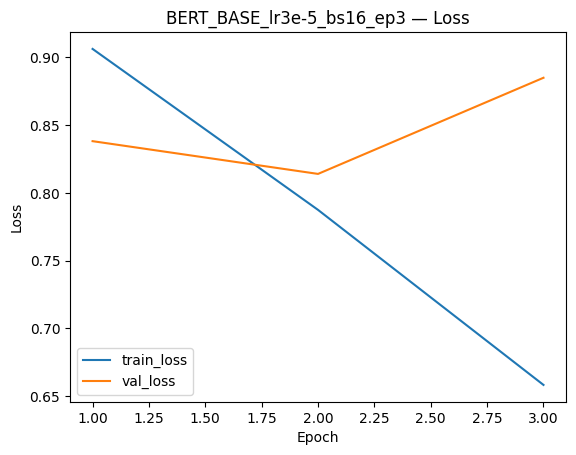

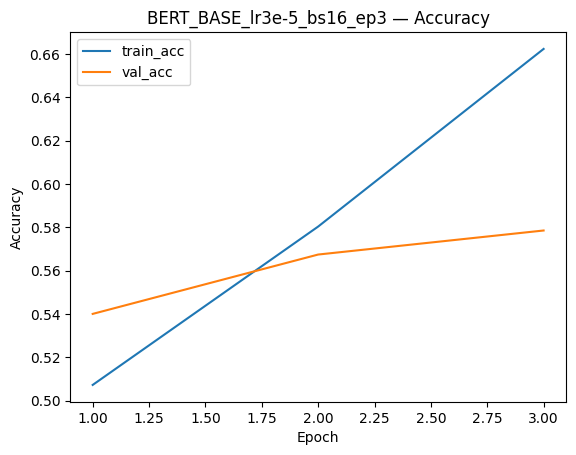


BERT_BASE_lr3e-5_bs16_ep3 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.8268    0.6867    0.7503      1050
      medium     0.5143    0.6181    0.5614      1050
        hard     0.4715    0.4562    0.4637      1050

    accuracy                         0.5870      3150
   macro avg     0.6042    0.5870    0.5918      3150
weighted avg     0.6042    0.5870    0.5918      3150


Confusion Matrix (rows=true, cols=pred):
[[721 116 213]
 [ 77 649 324]
 [ 74 497 479]]


In [ ]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs16_ep3",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 16,
    "epochs": 3,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)


ננסה לשנות את הגודל הצעד ולמנוע את האובר פיטינג

ניסוי 2


##########################################################################################
Run: BERT_BASE_lr2e-5_bs16_ep3
Model: bert-base-cased
Params: lr=2e-05, batch=16, epochs=3, optimizer=adamw, MAX_LEN=44
##########################################################################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.9106 train_acc=0.5096 | val_loss=0.8419 val_acc=0.5452
Epoch 2/3 | train_loss=0.7798 train_acc=0.5913 | val_loss=0.8329 val_acc=0.5635
Epoch 3/3 | train_loss=0.6733 train_acc=0.6630 | val_loss=0.8854 val_acc=0.5734


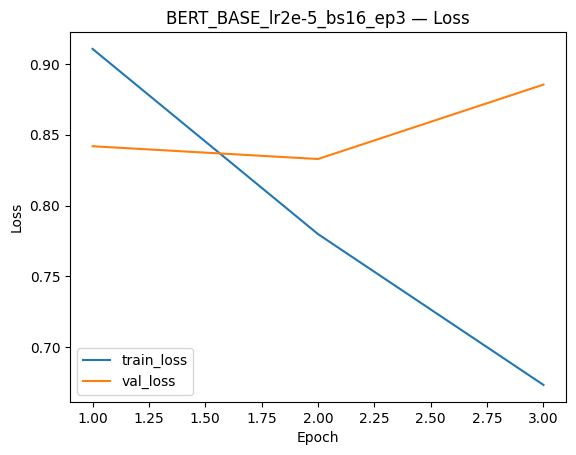

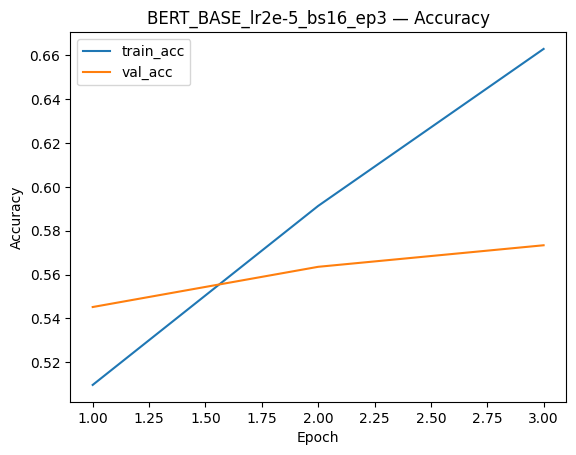


BERT_BASE_lr2e-5_bs16_ep3 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.7959    0.6943    0.7416      1050
      medium     0.5054    0.5819    0.5409      1050
        hard     0.4644    0.4533    0.4588      1050

    accuracy                         0.5765      3150
   macro avg     0.5885    0.5765    0.5804      3150
weighted avg     0.5885    0.5765    0.5804      3150


Confusion Matrix (rows=true, cols=pred):
[[729 123 198]
 [ 88 611 351]
 [ 99 475 476]]


In [ ]:
SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr2e-5_bs16_ep3",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 2e-5,
    "batch_size": 16,
    "epochs": 3,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)

נקבע את מספר הסיבובים ל2

 ניסוי 3   

הוא כמו ניסוי 1 רק עם 2 סיבובים


##########################################################################################
Run: BERT_BASE_lr3e-5_bs16_ep2
Model: bert-base-cased
Params: lr=3e-05, batch=16, epochs=2, optimizer=adamw, MAX_LEN=44
##########################################################################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 | train_loss=0.8932 train_acc=0.5156 | val_loss=0.8226 val_acc=0.5589
Epoch 2/2 | train_loss=0.7653 train_acc=0.5962 | val_loss=0.8279 val_acc=0.5718


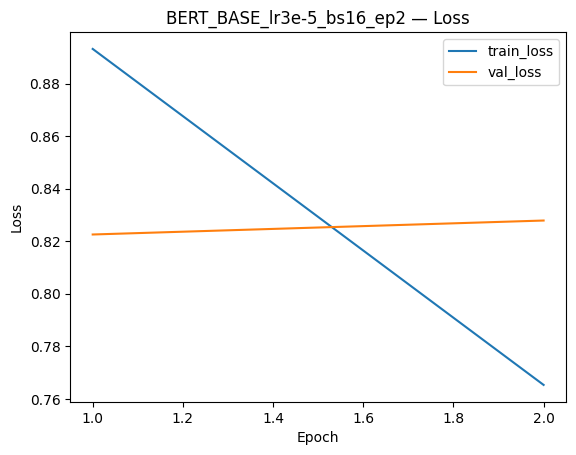

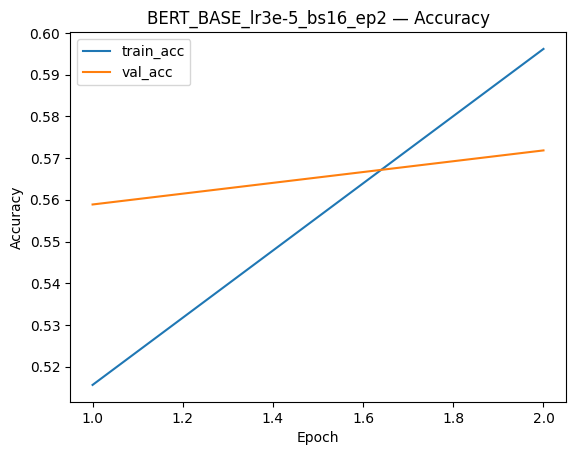


BERT_BASE_lr3e-5_bs16_ep2 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.8575    0.6648    0.7489      1050
      medium     0.4917    0.6800    0.5707      1050
        hard     0.4581    0.3857    0.4188      1050

    accuracy                         0.5768      3150
   macro avg     0.6025    0.5768    0.5795      3150
weighted avg     0.6025    0.5768    0.5795      3150


Confusion Matrix (rows=true, cols=pred):
[[698 156 196]
 [ 53 714 283]
 [ 63 582 405]]


In [ ]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs16_ep2",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 16,
    "epochs": 2,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)


נגדיל את גודל הבאץ


##########################################################################################
Run: BERT_BASE_lr3e-5_bs32_ep2
Model: bert-base-cased
Params: lr=3e-05, batch=32, epochs=2, optimizer=adamw, MAX_LEN=44
##########################################################################################


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 | train_loss=0.8992 train_acc=0.5085 | val_loss=0.8260 val_acc=0.5594
Epoch 2/2 | train_loss=0.7740 train_acc=0.5934 | val_loss=0.8224 val_acc=0.5704


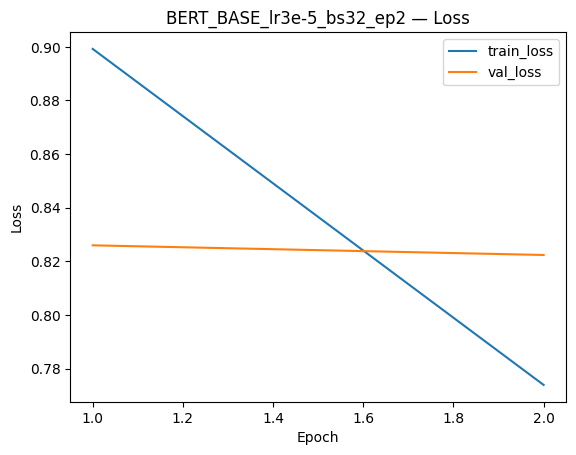

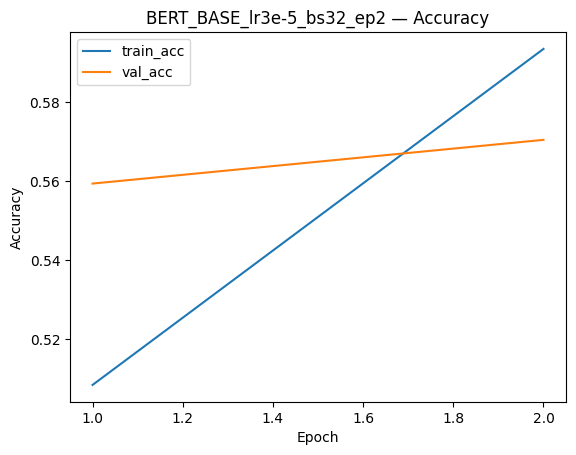


BERT_BASE_lr3e-5_bs32_ep2 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.8279    0.6829    0.7484      1050
      medium     0.4993    0.6352    0.5591      1050
        hard     0.4462    0.4029    0.4234      1050

    accuracy                         0.5737      3150
   macro avg     0.5911    0.5737    0.5770      3150
weighted avg     0.5911    0.5737    0.5770      3150


Confusion Matrix (rows=true, cols=pred):
[[717 118 215]
 [ 73 667 310]
 [ 76 551 423]]


In [ ]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs32_ep2",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 32,
    "epochs": 2,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)


--------------------------------------------------------------------------------


##########################################################################################
Run: BERT_BASE_lr3e-5_bs32_ep3
Model: bert-base-cased
Params: lr=3e-05, batch=32, epochs=3, optimizer=adamw, MAX_LEN=44
##########################################################################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.9125 train_acc=0.5104 | val_loss=0.8371 val_acc=0.5540
Epoch 2/3 | train_loss=0.7832 train_acc=0.5920 | val_loss=0.8110 val_acc=0.5770
Epoch 3/3 | train_loss=0.6659 train_acc=0.6701 | val_loss=0.8592 val_acc=0.5792


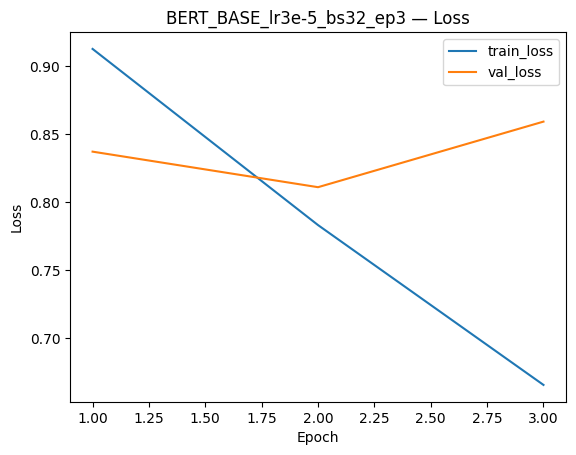

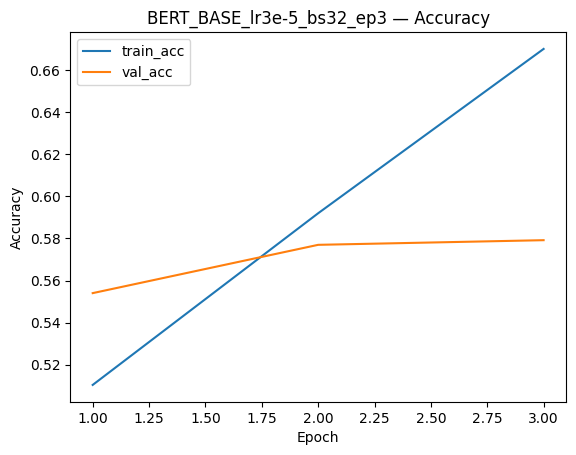


BERT_BASE_lr3e-5_bs32_ep3 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.7902    0.6886    0.7359      1050
      medium     0.5080    0.5714    0.5379      1050
        hard     0.4649    0.4667    0.4658      1050

    accuracy                         0.5756      3150
   macro avg     0.5877    0.5756    0.5798      3150
weighted avg     0.5877    0.5756    0.5798      3150


Confusion Matrix (rows=true, cols=pred):
[[723 121 206]
 [ 92 600 358]
 [100 460 490]]


In [14]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs32_ep3",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 32,
    "epochs": 3,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)



##########################################################################################
Run: BERT_BASE_lr3e-5_bs16_ep2
Model: bert-base-cased
Params: lr=3e-05, batch=8, epochs=2, optimizer=adamw, MAX_LEN=44
##########################################################################################


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 | train_loss=0.9050 train_acc=0.5117 | val_loss=0.8638 val_acc=0.5535
Epoch 2/2 | train_loss=0.7725 train_acc=0.5966 | val_loss=0.8280 val_acc=0.5712


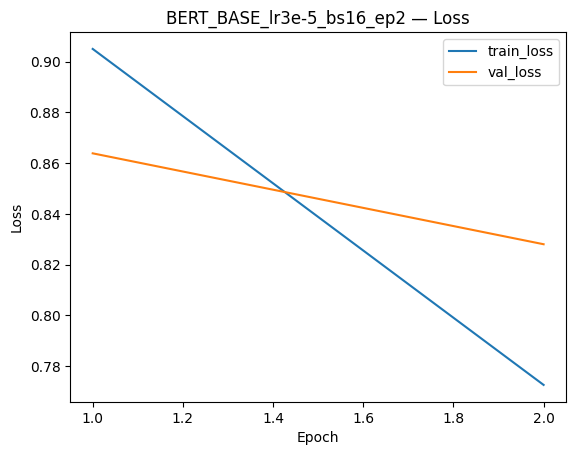

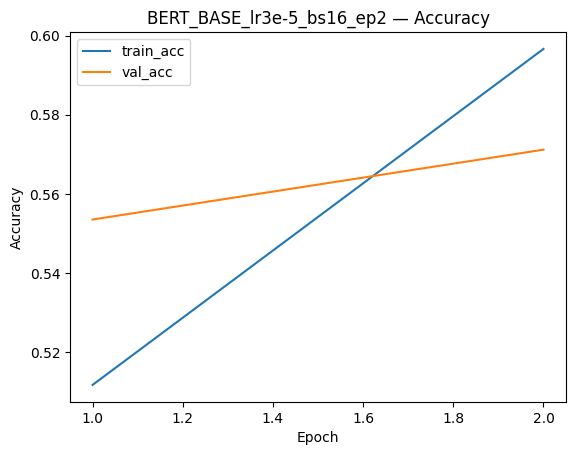


BERT_BASE_lr3e-5_bs16_ep2 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.8448    0.6895    0.7593      1050
      medium     0.5025    0.6752    0.5762      1050
        hard     0.4875    0.4095    0.4451      1050

    accuracy                         0.5914      3150
   macro avg     0.6116    0.5914    0.5935      3150
weighted avg     0.6116    0.5914    0.5935      3150


Confusion Matrix (rows=true, cols=pred):
[[724 148 178]
 [ 67 709 274]
 [ 66 554 430]]


In [11]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs8_ep2",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 8,
    "epochs": 2,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)



##########################################################################################
Run: BERT_BASE_lr3e-5_bs8_ep3
Model: bert-base-cased
Params: lr=3e-05, batch=8, epochs=3, optimizer=adamw, MAX_LEN=44
##########################################################################################


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.9163 train_acc=0.5121 | val_loss=0.8384 val_acc=0.5415
Epoch 2/3 | train_loss=0.7805 train_acc=0.5902 | val_loss=0.8289 val_acc=0.5702
Epoch 3/3 | train_loss=0.6219 train_acc=0.6960 | val_loss=0.9492 val_acc=0.5698


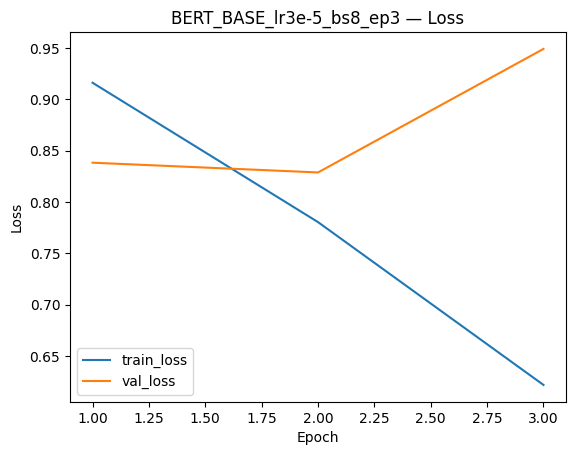

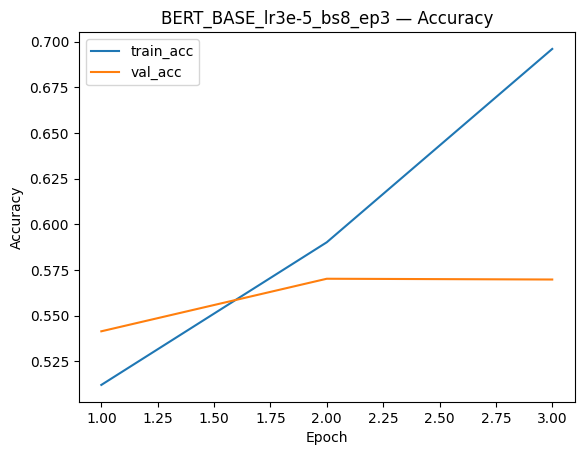


BERT_BASE_lr3e-5_bs8_ep3 — Test Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy     0.7723    0.7105    0.7401      1050
      medium     0.5057    0.5495    0.5267      1050
        hard     0.4612    0.4581    0.4596      1050

    accuracy                         0.5727      3150
   macro avg     0.5797    0.5727    0.5755      3150
weighted avg     0.5797    0.5727    0.5755      3150


Confusion Matrix (rows=true, cols=pred):
[[746 112 192]
 [103 577 370]
 [117 452 481]]


In [13]:
# ============================================================
# Single Experiment — Run ONE controlled fine-tuning experiment
# ============================================================

SINGLE_EXPERIMENT = {
    "run_name": "BERT_BASE_lr3e-5_bs8_ep3",
    "model": "bert-base-cased",   # or "bert-large-cased"
    "lr": 3e-5,
    "batch_size": 8,
    "epochs": 3,
    "optimizer": "adamw"          # "adam" or "adamw"
}

result = run_experiment(
    model_name=SINGLE_EXPERIMENT["model"],
    run_name=SINGLE_EXPERIMENT["run_name"],
    lr=SINGLE_EXPERIMENT["lr"],
    batch_size=SINGLE_EXPERIMENT["batch_size"],
    epochs=SINGLE_EXPERIMENT["epochs"],
    optimizer_name=SINGLE_EXPERIMENT["optimizer"]
)


Large Model Run

```
# This is formatted as code
```



Results Table

In [ ]:
# # ============================================================
# # Block 13 — (Optional) Results Table (Quick comparison)
# # ============================================================
# from sklearn.metrics import accuracy_score

# summary_rows = []
# for r in results:
#     acc = accuracy_score(r["y_true"], r["y_pred"])
#     summary_rows.append({
#         "run_name": r["run_name"],
#         "model": r["model_name"],
#         "lr": r["lr"],
#         "batch": r["batch_size"],
#         "epochs": r["epochs"],
#         "optimizer": r["optimizer"],
#         "test_acc": acc
#     })

# summary_df = pd.DataFrame(summary_rows).sort_values(by="test_acc", ascending=False)
# summary_df
